# Full CNN predictiong S&P500 Daily Closing Price
Full CNNs are becoming more commom to detect trends in NLP and time series modeling. A popular architecture is the WaveNet architecture proposed by Deep Mind in 2016. 

In WaveNet, every layer has kernel size 2, stride 1, causal padding, and using ReLU activation functions. However, the 2nd layer uses a dilation rate of 2. This means it skips every other input timestep. The next layer uses a dilation rate of 4 which means it skips every 3 input time steps. The fourth layer uses a dilation rate of 8 which means it skips every 7 timesteps out of 8. This patter continues which enables the lower layers to learn shorter term patterns while the deeper layers learn the longer term patterns.

The last layer acts as a dense layer to output a single value.

## Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import seaborn as sns
keras = tf.keras

from sklearn.preprocessing import MinMaxScaler

# set style of charts
sns.set(style="darkgrid")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)
  

def seq2seq_window_dataset(series, window_size, batch_size=128,
                           shuffle_buffer=1000):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)
  
def sequential_window_dataset(series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=window_size, drop_remainder=True)
    ds = ds.flat_map(lambda window: window.batch(window_size + 1))
    ds = ds.map(lambda window: (window[:-1], window[1:]))
    return ds.batch(1).prefetch(1)


def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [3]:
# Read in data
spy = pd.read_csv('SPY.csv')

# Convert series into datetime type
spy['Date'] = pd.to_datetime(spy['Date'])

# Save target series
series = spy['Close']

# Create train data set
train_split_date = '2014-12-31'
train_split_index = np.where(spy.Date == train_split_date)[0][0]
x_train = spy.loc[spy['Date'] <= train_split_date]['Close']

# Create test data set
test_split_date = '2019-01-02'
test_split_index = np.where(spy.Date == test_split_date)[0][0]
x_test = spy.loc[spy['Date'] >= test_split_date]['Close']

# Create valid data set
valid_split_index = (train_split_index.max(),test_split_index.min())
x_valid = spy.loc[(spy['Date'] < test_split_date) & (spy['Date'] > train_split_date)]['Close']

5521 5522 6527 6528 6949


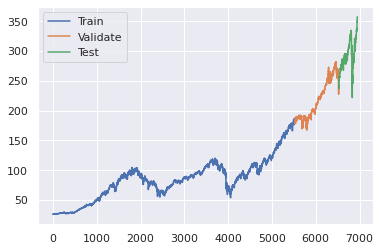

In [4]:
# Plot all lines on one chart to see where one segment starts and another ends
plt.plot(x_train, label = 'Train')
plt.plot(x_valid, label = 'Validate')
plt.plot(x_test, label = 'Test')
plt.legend()
print(x_train.index.max(),x_valid.index.min(),x_valid.index.max(),x_test.index.min(),x_test.index.max())

In [5]:
# Reshape values
x_train_values = x_train.values.reshape(-1, 1)
x_valid_values = x_valid.values.reshape(-1, 1)
x_test_values = x_test.values.reshape(-1, 1)

#  Create Scaler Object
x_train_scaler = MinMaxScaler(feature_range=(0, 1))

# Fit x_train values
normalized_x_train = x_train_scaler.fit_transform(x_train_values)

# Fit x_valid values
normalized_x_valid = x_train_scaler.transform(x_valid_values)

# Fit x_test values
normalized_x_test = x_train_scaler.transform(x_test_values)

# All values normalized to training data
spy_normalized_to_traindata = x_train_scaler.transform(series.values.reshape(-1, 1))

# Example of how to iverse
# inversed = scaler.inverse_transform(normalized_x_train).flatten()

## Fully Convolutional Forecasting - Wavenet

In [6]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 20
train_set = seq2seq_window_dataset(normalized_x_train, window_size,
                                   batch_size=128)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for dilation_rate in (1, 2, 4, 8, 16, 32):
    model.add(
      keras.layers.Conv1D(filters=32,
                          kernel_size=2,
                          strides=1,
                          dilation_rate=dilation_rate,
                          padding="causal",
                          activation="relu")
    )

model.add(keras.layers.Conv1D(filters=1, kernel_size=1))
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-4 * 10**(epoch / 30))

optimizer = keras.optimizers.Nadam(lr=1e-4)

model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
43/43 [==============================] - 1s 15ms/step - loss: 0.0801 - mae: 0.3453
Epoch 2/100
43/43 [==============================] - 1s 14ms/step - loss: 0.0578 - mae: 0.2904
Epoch 3/100
43/43 [==============================] - 1s 14ms/step - loss: 0.0255 - mae: 0.1873
Epoch 4/100
43/43 [==============================] - 1s 16ms/step - loss: 0.0107 - mae: 0.1092
Epoch 5/100
43/43 [==============================] - 1s 15ms/step - loss: 0.0086 - mae: 0.0990
Epoch 6/100
43/43 [==============================] - 1s 14ms/step - loss: 0.0063 - mae: 0.0821
Epoch 7/100
43/43 [==============================] - 1s 16ms/step - loss: 0.0043 - mae: 0.0657
Epoch 8/100
43/43 [==============================] - 1s 15ms/step - loss: 0.0028 - mae: 0.0499
Epoch 9/100
43/43 [==============================] - 1s 14ms/step - loss: 0.0016 - mae: 0.0344
Epoch 10/100
43/43 [==============================] - 1s 15ms/step - loss: 8.7841e-04 - mae: 0.0231
Epoch 11/100
43/43 [=========================

(0.0001, 0.1, 0.0, 0.1)

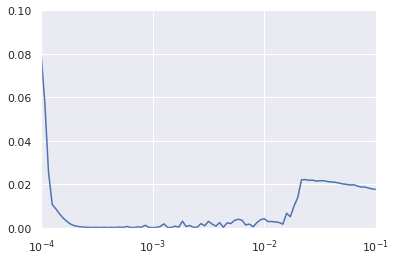

In [7]:
# Plot learning rate
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-4, 1e-1, 0, .1])

In [8]:
# Clear any background data that may have stored
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

# Create input sequence batches
window_size = 30
train_set = seq2seq_window_dataset(normalized_x_train, window_size,
                                   batch_size=128)
valid_set = seq2seq_window_dataset(normalized_x_valid, window_size,
                                   batch_size=128)

# Create model object and set up wavenet architecture
model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for dilation_rate in (1, 2, 4, 8, 16, 32):
    model.add(
      keras.layers.Conv1D(filters=128,
                          kernel_size=2,
                          strides=1,
                          dilation_rate=dilation_rate,
                          padding="causal",
                          activation="relu")
    )

# Add final dense layer
model.add(keras.layers.Conv1D(filters=1, kernel_size=1))

# Set Nadam as optimizer
optimizer = keras.optimizers.Nadam(lr=5e-4)

# Compile model
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# save best model 
model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint.h5", save_best_only=True)

# set early stopping
early_stopping = keras.callbacks.EarlyStopping(patience=50)

# sav history
history = model.fit(train_set, epochs=500,
                    validation_data=valid_set,
                    callbacks=[early_stopping, model_checkpoint])

Epoch 1/500
43/43 [==============================] - 1s 31ms/step - loss: 0.0051 - mae: 0.0703 - val_loss: 0.0063 - val_mae: 0.1019
Epoch 2/500
43/43 [==============================] - 1s 19ms/step - loss: 0.0013 - mae: 0.0258 - val_loss: 0.0023 - val_mae: 0.0593
Epoch 3/500
43/43 [==============================] - 1s 20ms/step - loss: 1.4693e-04 - mae: 0.0122 - val_loss: 6.7912e-04 - val_mae: 0.0303
Epoch 4/500
43/43 [==============================] - 1s 20ms/step - loss: 1.6410e-04 - mae: 0.0117 - val_loss: 0.0271 - val_mae: 0.2276
Epoch 5/500
43/43 [==============================] - 1s 21ms/step - loss: 0.0017 - mae: 0.0279 - val_loss: 0.0015 - val_mae: 0.0482
Epoch 6/500
43/43 [==============================] - 1s 21ms/step - loss: 7.2446e-05 - mae: 0.0090 - val_loss: 2.9009e-04 - val_mae: 0.0183
Epoch 7/500
43/43 [==============================] - 1s 20ms/step - loss: 4.9042e-04 - mae: 0.0164 - val_loss: 0.0068 - val_mae: 0.1125
Epoch 8/500
43/43 [==============================] -

In [9]:
# reload best model checkpoint
model = keras.models.load_model("my_checkpoint.h5")

In [10]:
# Use best model to get forecasts
cnn_forecast = model_forecast(model, spy_normalized_to_traindata[:,  np.newaxis], window_size)
cnn_forecast = cnn_forecast[x_test.index.min() - window_size:-1,-1,0]

In [11]:
# Scale back to normal
cnn_unscaled_forecast = x_train_scaler.inverse_transform(cnn_forecast.reshape(-1,1)).flatten()
cnn_unscaled_forecast.shape

(422,)

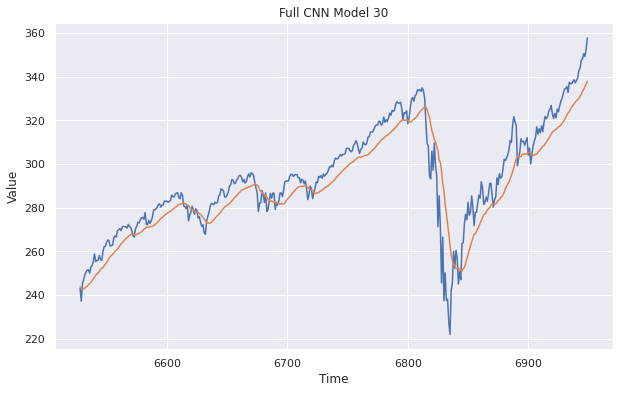

In [12]:
# Plot results
plt.figure(figsize=(10, 6))

plt.ylabel('Dollars $')
plt.xlabel('Timestep in Days')
plt.title(f'Full CNN Model {window_size}')
plot_series(x_test.index, x_test)
plot_series(x_test.index, cnn_unscaled_forecast)

In [13]:
# Calculate MAE
keras.metrics.mean_absolute_error(x_test, cnn_unscaled_forecast).numpy()

7.9851394